# Klasyfikacja ECAs na podstawie czułości na warunek początkowy

Jest to *przykładowe* rozwiązanie Zadania 6. Tworząc swoje rozwiązanie możesz skorzystać z fragmentów tego rozwiązania, ale jeśli to zrobisz to musisz zaproponować swoje modyfikacje - np. zamiast funkcji 'calculate_sensitivity' zdefiniowanej poniżej, musisz zaproponować jakiś swój pomiar wyliczający coś dla danego ECA. To 'coś' to może być miara częstości występowania danego bloku, miara tempa zmiany gęstości, miara odległości konfiguracji początkowej od końcowej itd itd... jakaś miara, która posłuży jako wartość, po której możemy klasyfikować reguły.

Zaczynamy od zdefiniowania funkcji generujących diagram czasoprzestrzenny (space-time diagram) wybranego ECA.

In [1]:
import numpy as np

def eca_get_lut(rule_num: int) -> np.ndarray:
  return np.array([int(x) for x in bin(rule_num)[2:].zfill(8)], dtype=np.uint8)

def eca_evolve(lut: np.ndarray, x: np.ndarray) -> np.ndarray:
  return lut[7 - (np.roll(x, 1) * 4 + x * 2 + np.roll(x, -1))]

def eca_evolve_spacetime(lut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(eca_evolve(lut, rows[-1]))
    return np.stack(rows)   

Następnie definiujemy funkcję do losowania konfiguracji początkowej.

In [2]:
def generate_random_initial_configuration(length: int) -> np.ndarray:
    return np.random.randint(2, size=length)

Następnie definiujemy funkcję, która liczy "odległość" między dwoma konfiguracjami. Jeśli obie podane konfiguracje są sobie równe, to odległość równa jest 0. Jeśli natomiast różnią się to odległość będzie > 0. Maksymalna wartość to 1 - w przypadku gdy konfiguracje różnią się w każdej komórce.

In [3]:
def conf_diff(conf1: np.ndarray, conf2: np.ndarray):
    return np.abs(conf1-conf2).sum() / conf1.shape[0]

Jesteśmy teraz gotowi do zdefiniowania funkcji, która dla danej konkretnej reguły ECA i danej konfiguracji początkowej oszacuje jej czułość na zmianę konfiguracji początkowej.

Robimy to w następujący sposób:
1. Dla zadanej konfiguracji początkowej tworzymy space-time diagram zawierający 'steps' kroków czasowych.
2. Wybieramy ostatnią konfigurację w wygenerowanym space-time diagramie i traktujemy ją jako "bazową".
3. Następnie w pętli po kolei zmieniamy pojedynczy stan w konfiguracji początkowej (kolejno pierwszy, lub drugi, lub trzeci itd) i dla każdej tak zmienionej konfiguracji początkowej również tworzymy space-time diagram zawierający 'steps' kroków i dla każego z nich wybieramy ostatnią z konfiguracji.
4. W ten sposób powstaje tyle nowych konfiguracji ile było komórek w podanej konfiguracji początkowej.
5. Otrzymane w kroku 3 i 4 konfiguracje porównujemy po kolei z konfiguracją "bazową" licząc odległości za pomocą 'conf_diff'.
6. Zwracamy maksymalną z otrzymanych odległości, która mówi o tym jak bardzo może różnić się wynik po 'steps' krokach jeśli w zadanej konfiguracji początkowej zmienimy któryś z pojedynczych stanów komórki. 

In [4]:
def calculate_sensitivity(rule_num: int, initial_config: np.ndarray, steps: int):
    #print(f"analyzing rule: {rule_num}") # for debug purpose
    
    lut = eca_get_lut(rule_num)
    base_result = eca_evolve_spacetime(lut, initial_config, steps)[-1]
    
    diffs = []
    
    for i in range(0, initial_config.shape[0]):
        config = initial_config.copy()
        config[i] = 1 - config[i]
        result = eca_evolve_spacetime(lut, config, steps)[-1]
        diffs.append(conf_diff(base_result, result))
    
    return max(diffs)

Teraz jesteśmy gotowi uruchomić nasz eksperyment dla wszystkich ECA. 
Generujemy jedeną, wspólną, losową konfigurację początkową, a następnie w pętli wywołujemy zdefiniowaną wcześniej funkcję 'calculate_sensitivity' dla każdego ECA i zapisujemy wynik w słowniku.

Eksperyment wykonamy dla konfiguracji początkowej zawierającej 99 komórek. Diagramy czasoprzestenne będą miały 99 kroków czasowych.
Zaczynamy od wygenerowania konfiguracji początkowej.

In [5]:
initial_configuration = generate_random_initial_configuration(99)

Następnie mając nasz warunek początkowy, w pętli mierzymy czułość każdej z 256 reguł ECA. Zwróć uwagę, że obliczenia mogą potrwać dłuższą chwilę, bo trzeba wyliczyć 100 razy diagram czaso-przestrzenny dla każdej z reguł.

In [6]:
result_list = [calculate_sensitivity(rule, initial_configuration, 99) for rule in range(256)]
results = dict(enumerate(result_list))

Okazuje się, że na większości współczesnych komputerów, możemy znacznie przyspieszyć powyższe obliczenia. Dlaczego?
Wynika to z faktu, że większość współczesnych procesorów ma więcej niż jeden rdzeń obliczeniowy (ang. core) i dzięki temu możliwe jest równoległe wykonywanie wielu obliczeń (tzn. w tym samym czasie można prowadzić obliczenia dla kilku reguł ECA).
Procesor mojego laptopa jest bardzo mocny - ma w sumie 12 rdzeni, z czego 8 to tak zwane "performance cores" cechujące się dużą wydajnością, a 4 to "efficiency cores" - wolniejsze, ale bardziej energo-oszczędne jednostki. Wydaje się więc, że w idealnym przypadku obliczenia mogłyby przyspieszyć nawet 12 razy - choć bardziej prawdopodobne jest przyspieszenie na poziomie 8-9x.

Jest kilka sposobów na uzyskanie tego efektu. Najprostszy to zastosowanie biblioteki joblib. Niestety trzeba ją sobie doinstalować do swojego Pythona za pomocą komendy pip / conda lub podobnej. Więcej o tej bibliotece: https://pypi.org/project/joblib/

In [7]:
from joblib import Parallel, delayed

result_list = Parallel(n_jobs=-1)(delayed(calculate_sensitivity)(rule, initial_configuration, 99) for rule in range(256))

results = dict(enumerate(result_list))

Jak pokazał mój przykład, czas obliczeń spadł z 28.7s na 3.3s czyli 8.7 razy szybciej! Zwróć uwagę, że uzyskaliśmy tak duże przyspieszenie zmieniając właściwie 1 linijkę kodu!

*Uwaga:* Jeśli masz problem z instalacją Joblib, bo na przykład nie masz uprawnień / dany system nie umożliwia instalacji dodatkowych bibliotek, podobny efekt można uzyskać wbudowanymi w Pythona mechanizmami, ale potrzebne będzie kilka dziwnych linijek kodu więcej - jak poniżej. Efekt będzie podobny, ale kod dużo mniej przyjemny. Zarówno *ProcessPoolExecutor* jak i *multiprocessing* to elementy standardu Python, ~~więc będą działać zawsze~~ (**UPDATE: niestety nie w systemach Windows w notebookach Jupyter.** Jeśli korzystasz z Linux lub MacOS możesz użyć poniższy kod. Jeśli używasz Windows - użyj Joblib lub uruchom Jupyter w ramach WSL - tj. Linux Subsystem for Windows.).

Eksperymenty pokazują, że ta metoda działa też nieco wydajniej (o ile działa) -  ma mniejszy narzut, bo joblib daje nam dodatkowe możliwości (z których w tym przykładzie nie korzystamy).

In [8]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

def my_task(rule):
     return calculate_sensitivity(rule, initial_configuration, 99)
   
with ProcessPoolExecutor(mp_context = multiprocessing.get_context("fork")) as executor:
        result_list = list(executor.map(my_task, range(256)))

results = dict(enumerate(result_list))

Aby zorientować się w sytuacji rysujemy otrzymane wyniki na prostym wykresie.

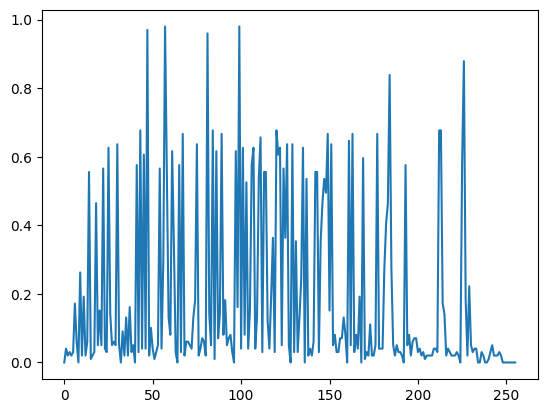

In [9]:
import matplotlib.pyplot as plt

plt.plot(results.keys(), results.values())

Z analizy wykres widzimy, że są conajmniej 4 różne klasy zachowań:
* Klasa 1: reguły gdzie maksymalna odległość policzona przez calculate_sensitivity wynosi 0 - czyli są zupełnie niezależne na zmiany w konfiguracji początkowej
* Klasa 2: reguły, które są czułe na zmianę w konfiguracji początkowej w stopniu minimalnym (odległość < 0.2)
* Klasa 3: reguły, które są czułe na zmianę w konfiguracji początkowej w stopniu średniom (odległość między 0.2 a 0.6)
* Klasa 4: reguły, które są czułe na zmianę w konfiguracji początkowej w stopniu maksymalnym (odległość większa niż 0.6)

Wartości 0.2 i 0.6 zostały wybrane "na oko" poprzez analizę rysunku. Oczywiście gdyby miara 'calculate_sensitivity' mierzyła coś innego, albo gdyby użyto innych konfiguracji początkowych (np. innej długości) te wartości graniczne mogłyby być inne. Co więcej nie jest powiedziane, że ten wybór jest idealny. Nie mniej dalsza część eksperymentu pokazuje, że wybór jest zaskakująco zbieżny z klasyfikacją Wolframa... stąd być może akurat te wartości w tym wariancie eksperymentu są sensowne. 

In [10]:
sensitivity_classes = [
 set([r for r in results.keys() if results[r] == 0]),         
 set([r for r in results.keys() if 0 < results[r] < 0.2]), 
 set([r for r in results.keys() if 0.2 <= results[r] < 0.6]),
 set([r for r in results.keys() if 0.6 <= results[r]]) 
]

for c, rules in enumerate(sensitivity_classes):
    print(f"Klasa {c+1}: {sorted(rules)}")

Klasa 1: [0, 8, 32, 40, 64, 96, 128, 136, 160, 168, 192, 224, 234, 235, 238, 239, 248, 249, 250, 251, 252, 253, 254, 255]
Klasa 2: [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 23, 24, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 42, 44, 46, 48, 49, 50, 51, 52, 53, 55, 59, 60, 63, 66, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 85, 87, 88, 90, 91, 92, 93, 94, 95, 98, 100, 102, 104, 105, 108, 109, 112, 115, 116, 117, 119, 123, 127, 130, 132, 133, 138, 139, 140, 141, 144, 150, 152, 153, 154, 155, 156, 157, 158, 159, 162, 164, 165, 166, 167, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 186, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 227, 228, 230, 231, 232, 233, 236, 237, 240, 241, 242, 243, 244, 245, 246, 247]
Klasa 3: [9, 14, 18, 22, 41, 54, 56, 58, 62, 65, 103, 106, 110, 113, 114, 118, 124, 125, 131, 134, 137, 142, 143, 145, 146, 

Mając tak zdefiniowane klasy możemy porównać je z klasami podanymi przez S. Wolframa na bazie analizy space-time diagramów. 
Oczywiście kryteria Wolframa były inne niż nasze, stąd otrzymane klasy mogą się nie powtarzać, ale być może znajdziemy pewne podobieństwa?

Rysunek pokazuje swoistą skalę zgodności klas. Jak widać Klasy 1 i 2 właściwie się niemal pokrywają w obu klasyfikacjach. Klasy 3 i 4 są natomiast nieco różne. 

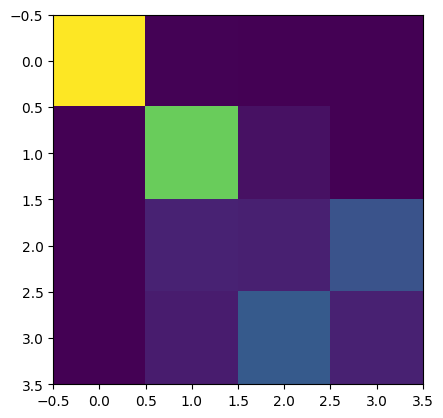

In [11]:
# table based on:
# https://www.researchgate.net/publication/241278966_A_Note_on_Elementary_Cellular_Automata_Classification
# manually processed from the article text
wolfram_classes = [
    {0, 8, 32, 40, 64, 96, 128, 136, 160, 168, 192, 224, 234, 235, 238, 239, 248, 249, 250, 251, 252, 253, 254, 255},
    {1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36,
     37, 38, 39, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71,
     72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 91, 92, 93, 94, 95, 98, 99, 100, 103, 104, 108, 109,
     111, 112, 113, 114, 115, 116, 117, 118, 119, 123, 125, 127, 130, 131, 132, 133, 134, 138, 139, 140, 141, 142, 143,
     144, 145, 148, 152, 154, 155, 156, 157, 158, 159, 162, 163, 164, 166, 167, 170, 171, 172, 173, 174, 175, 176, 177,
     178, 179, 180, 181, 184, 185, 186, 187, 188, 189, 190, 191, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
     206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229,
     230, 231, 232, 233, 236, 237, 240, 241, 242, 243, 245, 246, 247},
    {18, 22, 30, 45, 60, 75, 86, 89, 90, 101, 102, 105, 122, 126, 129, 135, 146, 149, 150, 151, 153, 161, 165, 182, 183,
     195},
    {41, 54, 97, 106, 107, 110, 120, 121, 124, 137, 147, 169, 193, 225}
]

cov = np.zeros(shape=(4,4))

for sc_idx, sc in enumerate(sensitivity_classes):
    for wc_idx, wc in enumerate(wolfram_classes):
        inter = sc & wc # intersection of two sets
        union = sc | wc # union of two sets
        cov[sc_idx][wc_idx] =  len(inter) / len(union)
        
plt.imshow(cov)

Co ciekawe jednak, jeśli w naszej klasyfikacji opartej na czułości zamienimy Klasy 3 i 4 miejscami dostanimy bardzo dużą zgodność z klasyfikacją Wolframa, co widać na rysunku przez fakt, że przekątna jest najbardziej wyraźna...

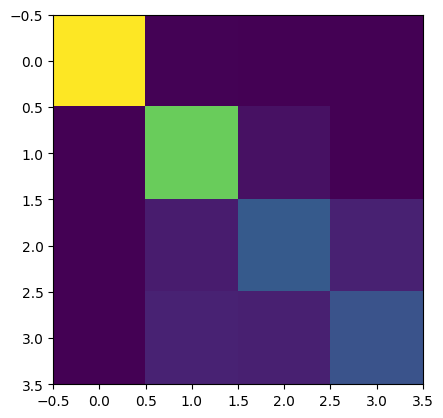

In [12]:
sensitivity_classes2 = [sensitivity_classes[0], sensitivity_classes[1], sensitivity_classes[3], sensitivity_classes[2]]

cov = np.zeros(shape=(4,4))

for sc_idx, sc in enumerate(sensitivity_classes2):
    for wc_idx, wc in enumerate(wolfram_classes):
        inter = sc & wc # intersection of two sets
        union = sc | wc # union of two sets
        cov[sc_idx][wc_idx] =  len(inter) / len(union)
        
plt.imshow(cov)